### Take Stock price Prediction of any company you
- Have to predicts Netflix Stock price by using LSTM on Jupyter notebook.

#### Import Libraries

- Import necessary libaries for the following csv file to be pre-processed

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

## Data Pre-Processing

In [2]:
netflix = pd.read_csv('Dataset Netflix.csv', encoding='unicode_escape')
netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


- Once the files are imported, pre-processing of data is initiated by checking the shape, datatype and null values

In [3]:
netflix.shape

(5044, 7)

In [4]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


- Now, the datatype for 'Date' column needs to be changed to datetime, as the column is in obejct type

In [5]:
netflix['Date'] = pd.to_datetime(netflix['Date'])
netflix.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

- After the column is converted, extraction and creation of columns such as 'Year','Month' and 'Day' is initiated using Slicer and Lambda function

In [6]:
netflix['Year'] = netflix['Date'].apply(lambda x : str(x)[:4])
netflix['Month'] = netflix['Date'].apply(lambda x : str(x)[5:7])
netflix['Day'] = netflix['Date'].apply(lambda x : str(x)[8:10])
netflix.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2002,05,29
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,2002,05,30


In [7]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5044 non-null   datetime64[ns]
 1   Open       5044 non-null   float64       
 2   High       5044 non-null   float64       
 3   Low        5044 non-null   float64       
 4   Close      5044 non-null   float64       
 5   Adj Close  5044 non-null   float64       
 6   Volume     5044 non-null   int64         
 7   Year       5044 non-null   object        
 8   Month      5044 non-null   object        
 9   Day        5044 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 394.2+ KB


In [8]:
class color:    
    GREEN, RED = '\033[92m', '\033[91m'
    BOLD, UNDERLINE, END = '\033[1m', '\033[4m', '\033[0m'
    GREEN_BOLD = GREEN + BOLD
    RED_BOLD = RED + BOLD
    GREEN_BOLD_UND = GREEN_BOLD + UNDERLINE   
    
rb, gb,  = color.RED_BOLD, color.GREEN_BOLD
gbu, end = color.GREEN_BOLD_UND, color.END

- From the dataset, it is clearly inferred that it contains 5044 rows and 10 columns with having no null values respectively

In [9]:
# Print the number of trading days
print(f'{rb}Total number of trading days: {end}{gbu}{netflix.shape[0]}{end}')
print(f'{rb}Total number of fields: {end}{gbu}{netflix.shape[1]}{end}')
print('\n')
# Check the Null and NA values
print(f'{rb}Null values: {end}{gbu}{netflix.isnull().values.sum()}{end}')
print(f'{rb}NA values: {end}{gbu}{netflix.isna().values.any()}{end}')

Total number of trading days: 5044
Total number of fields: 10


Null values: 0
NA values: False


- After pre-processing of data is completed successfully, a new dataset is created for 'Open' column using a new variable name and converting it into a Numpy array

In [10]:
netflix_df = netflix['Open'].values

In [12]:
netflix_df = netflix_df.reshape(-1, 1)

- The dataset is now split using train and test models for model prediction using LSTM

## Training and Testing of Dataset

In [14]:
netflix_train = np.array(netflix_df[:int(netflix_df.shape[0]*0.8)])
netflix_test = np.array(netflix_df[int(netflix_df.shape[0]*0.8):])

- The feature selection of the dataset is accomplished using MinMaxScaler by converting input values between 0 to 1

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
netflix_train = scaler.fit_transform(netflix_train)
netflix_test = scaler.transform(netflix_test)

- Additionally, a helper function is created using define function for 50 timesteps. To explain in detail, the last 50 prices are taken to predict the next price

In [18]:
def create_dataset(netflix_df):
    x = []
    y = []
    for i in range(50, netflix_df.shape[0]):
        x.append(netflix_df[i-50:i, 0]) 
        y.append(netflix_df[i, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [19]:
x_train, y_train = create_dataset(netflix_train)
x_test, y_test = create_dataset(netflix_test)

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

- Once the reshape of data is made into a 3D array for using it in a LSTM Layer

## LSTM Model Building

In [21]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [23]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')

- Training the model using hyperparameters

## Predicitve Analysis

In [25]:
epochs = 40
batch_size = 64 

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

Epoch 1/40
63/63 [==============================] - 20s 198ms/step - loss: 0.0040
Epoch 2/40
63/63 [==============================] - 13s 208ms/step - loss: 7.7495e-04
Epoch 3/40
63/63 [==============================] - 12s 193ms/step - loss: 5.7836e-04
Epoch 4/40
63/63 [==============================] - 13s 202ms/step - loss: 7.1644e-04
Epoch 5/40
63/63 [==============================] - 12s 198ms/step - loss: 9.5911e-04
Epoch 6/40
63/63 [==============================] - 12s 194ms/step - loss: 5.9470e-04
Epoch 7/40
63/63 [==============================] - 12s 197ms/step - loss: 5.4604e-04
Epoch 8/40
63/63 [==============================] - 13s 203ms/step - loss: 4.8612e-04
Epoch 9/40
63/63 [==============================] - 12s 198ms/step - loss: 6.5263e-04
Epoch 10/40
63/63 [==============================] - 12s 187ms/step - loss: 5.3924e-04
Epoch 11/40
63/63 [==============================] - 12s 193ms/step - loss: 5.1609e-04
Epoch 12/40
63/63 [==============================] - 12s

INFO:tensorflow:Assets written to: stock_prediction\assets


In [26]:
# Load the model
model = load_model('stock_prediction')

In [27]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

30/30 [==============================] - 2s 36ms/step


- Once analysis is done, we have to use lineplot to find out the difference between predicted price and original price of the Netflix Dataset

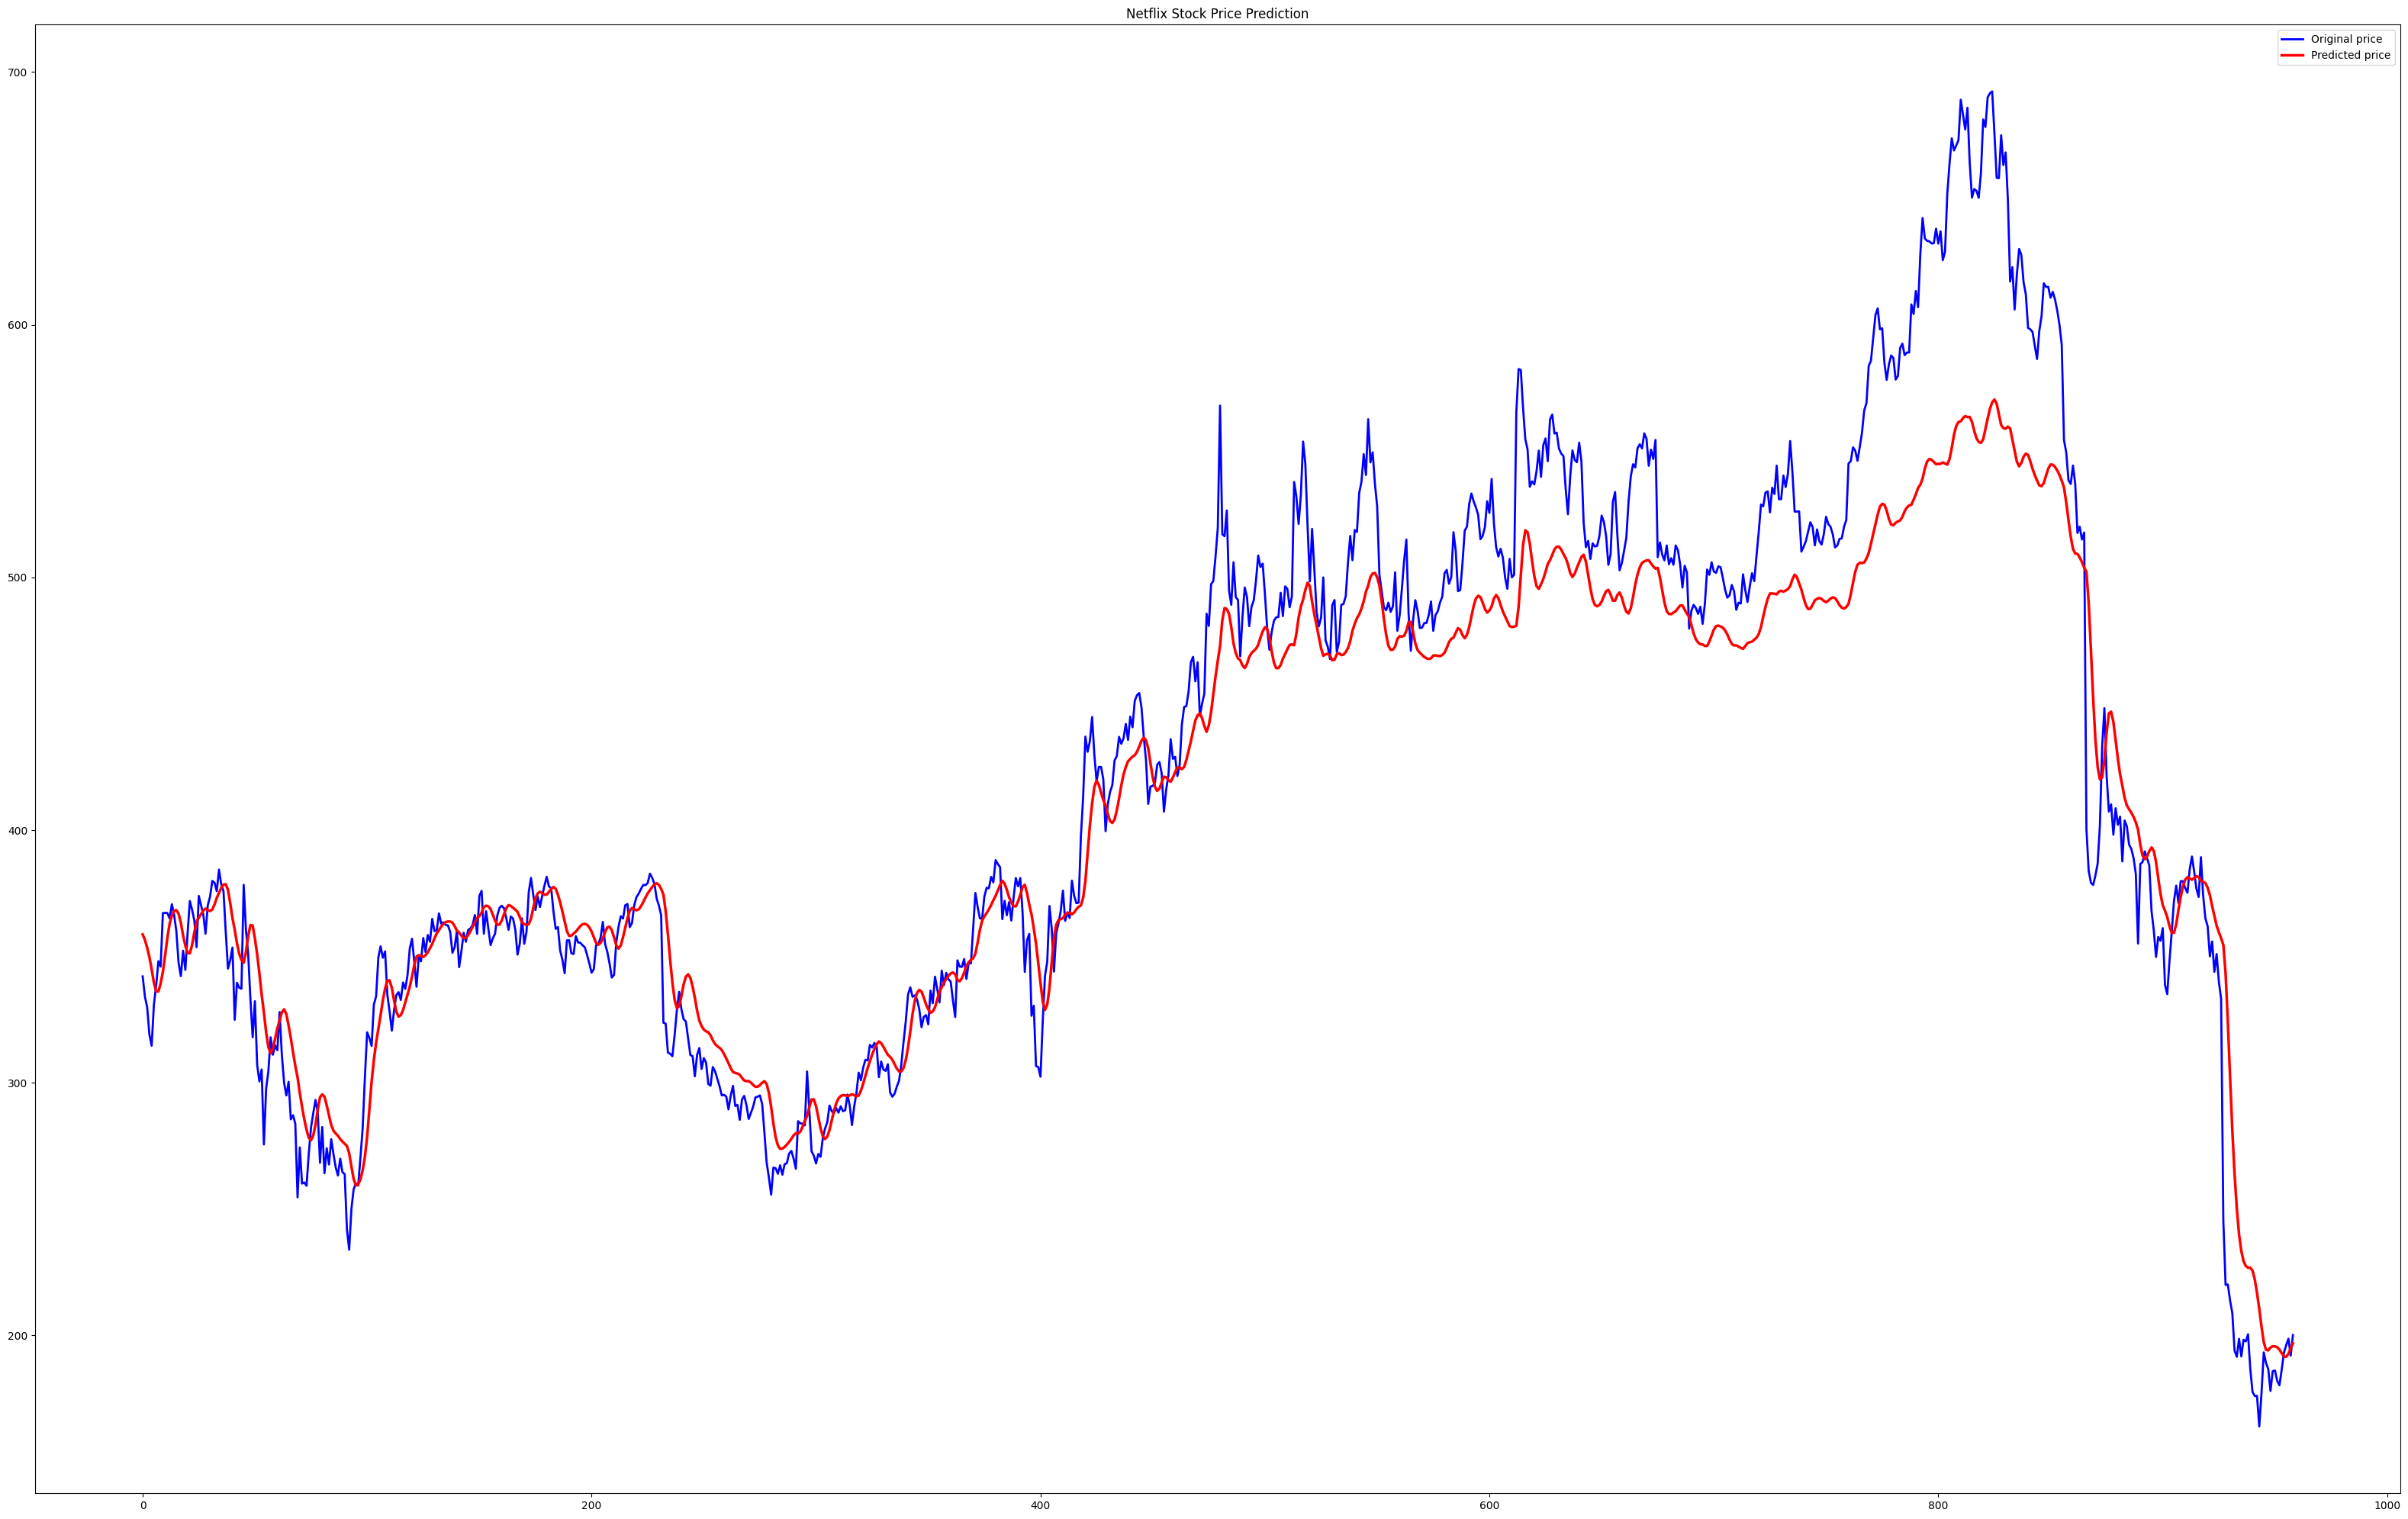

In [32]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(40,25))
ax.plot(y_test_scaled, color='blue', linewidth=2, label='Original price')
plt.plot(predictions, color='red', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend();

- We can clearly infer from this visualization, that the original price and predicited price as very similar by taking the appending the last 50 prices from the dataset

- This shows that the model has good accuracy and precision for prediction analysis

### Conclusion:

- Coding by Ananta Kumaar V R.
- Thanks to Bharat Intern for this wonderful oppurtunity for providing a Data Science Internship which was a great experience.